## About the dataset

This dataset is taken from Kaggle: [Sleep Data](https://www.kaggle.com/datasets/danagerous/sleep-data?select=sleepdata.csv). It tracks the sleep cycles of a particular user from [2014-2018](../data/raw/sleepdata.csv) and [2018-2022](../data/raw/sleepdata_2.csv).

Both datasets have Start, End, and Sleep Quality (target) columns. Both datasets also have a few other faetures, but the data from 2018-2022 (sleepdata_2.csv) contains additional columns that the 2014-2018 (sleepdata.csv) data does not have. 

In [75]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import (
    TimeSeriesSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from datetime import datetime



## 1. initial cleaning

### a) concatenating datasets horizontally

In [76]:
df1 = pd.read_csv("../data/raw/sleepdata.csv", sep=";", parse_dates=["Start", "End"])
print(df1.shape)
df1.head()

(887, 8)


,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps)
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100%,8:32,:),NaN,59.0,0
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3%,0:16,:|,Stressful day,72.0,0
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98%,8:30,:|,NaN,57.0,0
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65%,7:32,NaN,NaN,NaN,0
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72%,6:44,:),Drank coffee:Drank tea,68.0,0


In [77]:
df2 = pd.read_csv("../data/raw/sleepdata_2.csv", sep=";", parse_dates=["Start", "End", "Window start", "Window stop"])
print(df2.shape)
df2.head()

(921, 21)


,Start,End,Sleep Quality,Regularity,Mood,Heart rate (bpm),Steps,Alarm mode,Air Pressure (Pa),City,...,Time in bed (seconds),Time asleep (seconds),Time before sleep (seconds),Window start,Window stop,Did snore,Snore time,Weather temperature (°C),Weather type,Notes
0,2019-05-12 23:26:13,2019-05-13 06:11:03,60%,0%,NaN,0,8350,Normal,NaN,NaN,...,24289.2,22993.8,161.9,2019-05-13 06:00:00,2019-05-13 06:00:00,True,92.0,0.0,No weather,NaN
1,2019-05-13 22:10:31,2019-05-14 06:10:42,73%,0%,NaN,0,4746,Normal,NaN,NaN,...,28810.2,25160.9,192.1,2019-05-14 05:50:00,2019-05-14 05:50:00,True,0.0,0.0,No weather,NaN
2,2019-05-14 21:43:00,2019-05-15 06:10:41,86%,96%,NaN,0,4007,Normal,NaN,NaN,...,30461.5,28430.8,203.1,2019-05-15 05:50:00,2019-05-15 05:50:00,True,74.0,0.0,No weather,NaN
3,2019-05-15 23:11:51,2019-05-16 06:13:59,77%,92%,NaN,0,6578,Normal,NaN,NaN,...,25327.6,23132.5,168.9,2019-05-16 05:50:00,2019-05-16 05:50:00,True,0.0,0.0,No weather,NaN
4,2019-05-16 23:12:13,2019-05-17 06:20:32,78%,94%,NaN,0,4913,Normal,NaN,NaN,...,25698.4,22614.6,171.3,2019-05-17 05:50:00,2019-05-17 05:50:00,True,188.0,0.0,No weather,NaN


In [78]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Start                        921 non-null    datetime64[ns]
 1   End                          921 non-null    datetime64[ns]
 2   Sleep Quality                921 non-null    object        
 3   Regularity                   921 non-null    object        
 4   Mood                         0 non-null      float64       
 5   Heart rate (bpm)             921 non-null    int64         
 6   Steps                        921 non-null    int64         
 7   Alarm mode                   921 non-null    object        
 8   Air Pressure (Pa)            492 non-null    float64       
 9   City                         487 non-null    object        
 10  Movements per hour           921 non-null    float64       
 11  Time in bed (seconds)        921 non-null    

In [79]:
pd.to_timedelta(df1["Time in bed"] + ":00").dt.total_seconds() / 3600
df1["Time in bed (hr)"] = pd.to_timedelta(df1["Time in bed"] + ":00").dt.total_seconds() / 3600

In [80]:
df1 = df1.drop(columns=["Wake up", "Sleep Notes", "Time in bed"])
df2 = df2.drop(columns=["Mood", "Notes"])

In [81]:
df2["Time in bed (hr)"] = df2["Time in bed (seconds)"] / 3600
rows_to_move = ['Start', 'End', 'Sleep Quality', 'Heart rate (bpm)', 'Steps', 'Time in bed (hr)']
df2 = df2.drop(columns=["Time in bed (seconds)"])
row_order = rows_to_move + [c for c in df2.columns if c not in rows_to_move]
df2 = df2[row_order]

df1 = df1.rename(columns={"Heart rate": "Heart rate (bpm)", "Activity (steps)": "Steps"})
df2 = df2.rename(columns={"Sleep Quality": "Sleep quality"})

In [82]:
df = pd.concat([df1, df2], ignore_index=True, sort=False)
df = df.reset_index(drop=True)
print(df.shape)
df.iloc[886:890]

(1808, 19)


,Start,End,Sleep quality,Heart rate (bpm),Steps,Time in bed (hr),Regularity,Alarm mode,Air Pressure (Pa),City,Movements per hour,Time asleep (seconds),Time before sleep (seconds),Window start,Window stop,Did snore,Snore time,Weather temperature (°C),Weather type
886,2018-02-16 22:52:29,2018-02-17 07:48:04,91%,NaN,2291,8.916667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
887,2019-05-12 23:26:13,2019-05-13 06:11:03,60%,0.0,8350,6.747000,0%,Normal,NaN,NaN,35.0,22993.8,161.9,2019-05-13 06:00:00,2019-05-13 06:00:00,True,92.0,0.0,No weather
888,2019-05-13 22:10:31,2019-05-14 06:10:42,73%,0.0,4746,8.002833,0%,Normal,NaN,NaN,78.6,25160.9,192.1,2019-05-14 05:50:00,2019-05-14 05:50:00,True,0.0,0.0,No weather
889,2019-05-14 21:43:00,2019-05-15 06:10:41,86%,0.0,4007,8.461528,96%,Normal,NaN,NaN,60.5,28430.8,203.1,2019-05-15 05:50:00,2019-05-15 05:50:00,True,74.0,0.0,No weather


### b) further cleaning: removing naps, data integrity (datatypes, nan values)

#### i) histograms are a useful tool to scan for some weird things

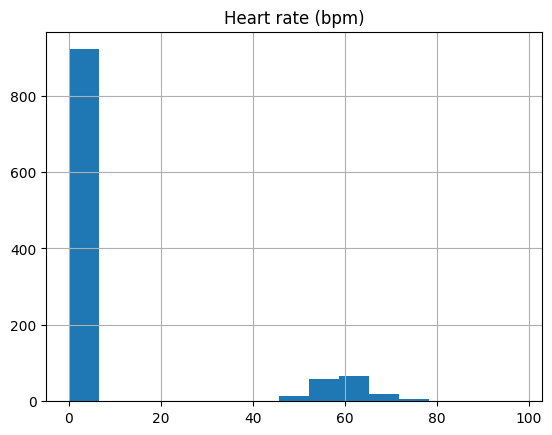

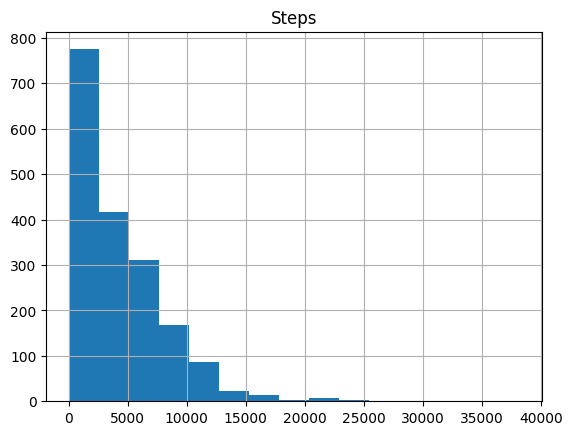

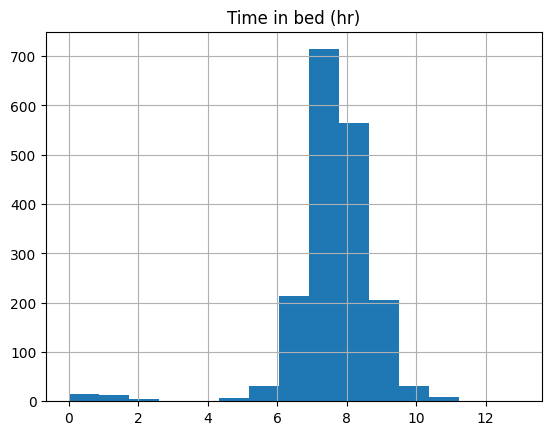

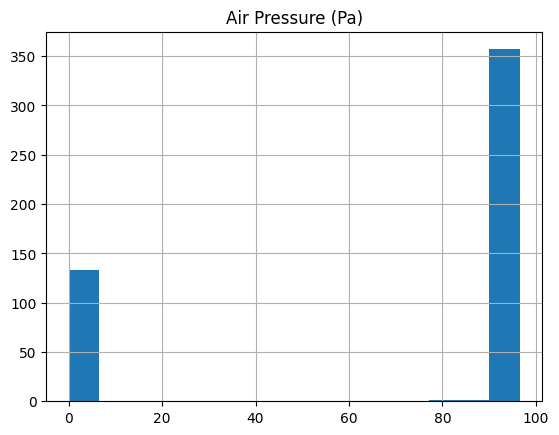

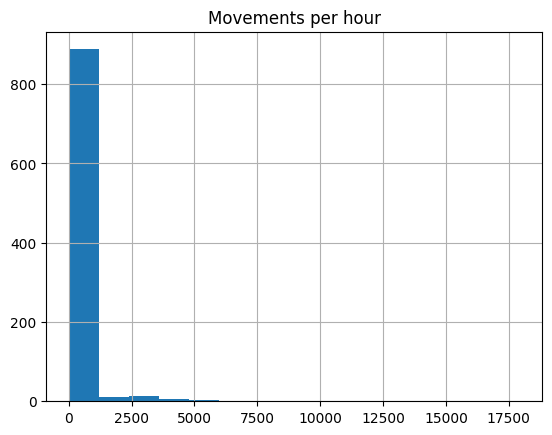

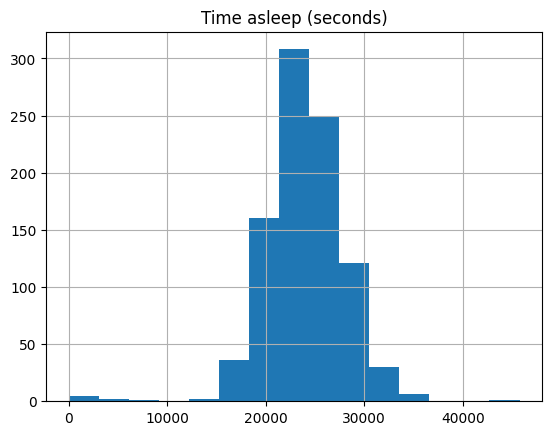

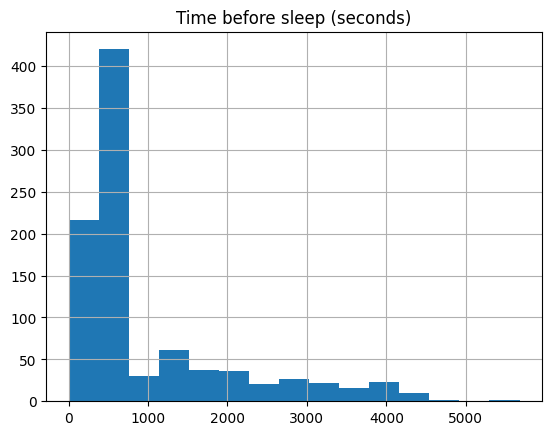

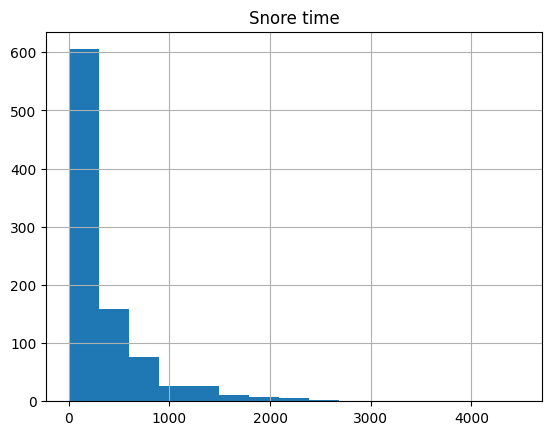

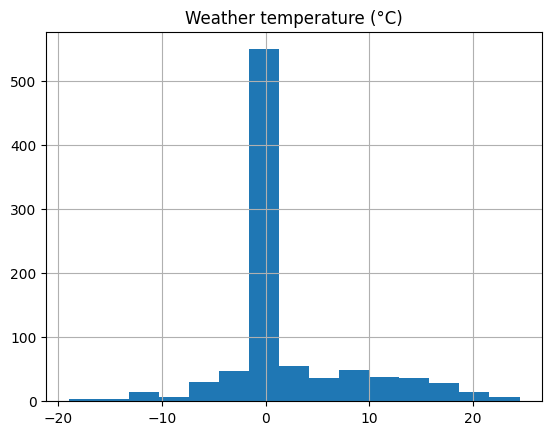

In [83]:
for col in df.select_dtypes("number").columns:  
    plt.figure()
    plt.title(col)
    df[col].hist(bins=15)

noticeable issues: naps, 0 bpm heartrate, 0 steps

#### i) removing naps

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1808 entries, 0 to 1807
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Start                        1808 non-null   datetime64[ns]
 1   End                          1808 non-null   datetime64[ns]
 2   Sleep quality                1808 non-null   object        
 3   Heart rate (bpm)             1083 non-null   float64       
 4   Steps                        1808 non-null   int64         
 5   Time in bed (hr)             1808 non-null   float64       
 6   Regularity                   921 non-null    object        
 7   Alarm mode                   921 non-null    object        
 8   Air Pressure (Pa)            492 non-null    float64       
 9   City                         487 non-null    object        
 10  Movements per hour           921 non-null    float64       
 11  Time asleep (seconds)        921 non-null  

<Axes: >

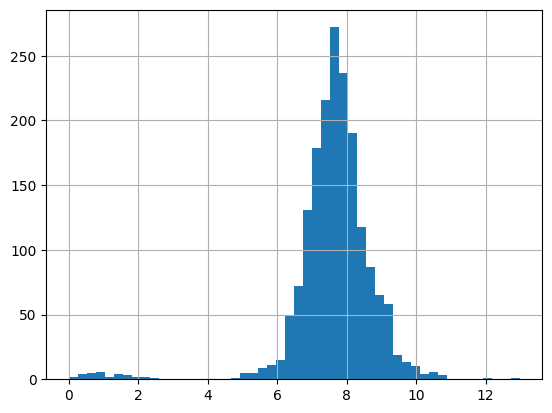

In [85]:
df["Time in bed (hr)"].hist(bins=50)

In [86]:
df = df[df["Time in bed (hr)"] >= 3.5]
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1777 entries, 0 to 1776
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Start                        1777 non-null   datetime64[ns]
 1   End                          1777 non-null   datetime64[ns]
 2   Sleep quality                1777 non-null   object        
 3   Heart rate (bpm)             1072 non-null   float64       
 4   Steps                        1777 non-null   int64         
 5   Time in bed (hr)             1777 non-null   float64       
 6   Regularity                   913 non-null    object        
 7   Alarm mode                   913 non-null    object        
 8   Air Pressure (Pa)            487 non-null    float64       
 9   City                         480 non-null    object        
 10  Movements per hour           913 non-null    float64       
 11  Time asleep (seconds)        913 non-null  

initially 1808 rows, now 1777 rows. 31 naps removed

#### ii) 0 bpm, 0 steps

In [87]:
def count_zeros_nans(cols):
    for c in cols:
        zeros = df[c].eq(0).sum()
        print(f"zeros for {c}: {zeros}")

        nans = df[c].isna().sum()
        print(f"nans for {c}: {nans}")

In [88]:
cols_zeros_nans = ["Heart rate (bpm)", "Steps"]
count_zeros_nans(cols_zeros_nans)

zeros for Heart rate (bpm): 913
nans for Heart rate (bpm): 705
zeros for Steps: 417
nans for Steps: 0


In [89]:
df = df.replace(0, np.nan)

In [90]:
count_zeros_nans(cols_zeros_nans)

zeros for Heart rate (bpm): 0
nans for Heart rate (bpm): 1618
zeros for Steps: 0
nans for Steps: 417


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1777 entries, 0 to 1776
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Start                        1777 non-null   datetime64[ns]
 1   End                          1777 non-null   datetime64[ns]
 2   Sleep quality                1777 non-null   object        
 3   Heart rate (bpm)             159 non-null    float64       
 4   Steps                        1360 non-null   float64       
 5   Time in bed (hr)             1777 non-null   float64       
 6   Regularity                   913 non-null    object        
 7   Alarm mode                   913 non-null    object        
 8   Air Pressure (Pa)            354 non-null    float64       
 9   City                         480 non-null    object        
 10  Movements per hour           912 non-null    float64       
 11  Time asleep (seconds)        913 non-null  

#### iii) sleep quality and regularity to numeric

In [92]:
pct_cols = ["Sleep quality", "Regularity"]
df[pct_cols] = df[pct_cols].apply(lambda x: x.str.replace("%", "").astype(float))
df[pct_cols] = df[pct_cols] / 100

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1777 entries, 0 to 1776
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Start                        1777 non-null   datetime64[ns]
 1   End                          1777 non-null   datetime64[ns]
 2   Sleep quality                1777 non-null   float64       
 3   Heart rate (bpm)             159 non-null    float64       
 4   Steps                        1360 non-null   float64       
 5   Time in bed (hr)             1777 non-null   float64       
 6   Regularity                   913 non-null    float64       
 7   Alarm mode                   913 non-null    object        
 8   Air Pressure (Pa)            354 non-null    float64       
 9   City                         480 non-null    object        
 10  Movements per hour           912 non-null    float64       
 11  Time asleep (seconds)        913 non-null  

#### iv) checking other object types are categorical

In [94]:
def check_unique_values(cols):
    for c in cols:
        print(f"unique values for {c}")
        print(df[c].unique().tolist())
        print("===============================")


In [95]:
cols_check_unique = df.select_dtypes(include=["object"]).columns
check_unique_values(cols_check_unique)

unique values for Alarm mode
[nan, 'Normal', 'No alarm']
unique values for City
[nan, 'Nelson', 'Fruitvale', 'View Royal', 'Central Kootenay', 'North Okanagan']
unique values for Did snore
[nan, True]
unique values for Weather type
[nan, 'No weather', 'Sunny', 'Fair', 'Partly cloudy', 'Cloudy', 'Snow', 'Fog', 'Rain', 'Rainy showers']


Boolean column Did snore should be treated as numeric

## 2. Baseline with no time

### a) functions: preprocess_features, eval_on_features

In [150]:
# Code credit: Adapted from
# https://ubc-cs.github.io/cpsc330-2025W1/lectures/notes/19_time-series.html#feature-engineering-for-date-time-columns


def preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    drop_features,
    target
):

    all_features = set(numeric_features + categorical_features + drop_features + target)
    if set(train_df.columns) != all_features:
        print("Missing columns", set(train_df.columns) - all_features)
        print("Extra columns", all_features - set(train_df.columns))
        raise Exception("Columns do not match")

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="median"), StandardScaler()
    )
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    )

    preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
        ("drop", drop_features),
    )

    preprocessor.fit(train_df)
    new_columns = preprocessor.get_feature_names_out()

    X_train_enc = pd.DataFrame(
        preprocessor.transform(train_df), index=train_df.index, columns=new_columns
    )
    X_test_enc = pd.DataFrame(
        preprocessor.transform(test_df), index=test_df.index, columns=new_columns
    )

    y_train = train_df[target[0]]
    y_test = test_df[target[0]]

    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

In [151]:
# Code credit: Adapted from
# https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/

def eval_on_features(
    X_train,
    X_test,
    y_train,
    y_test,
    regressor,
    xtick_labels = None,
    sales_data=False,
    ylabel="Sleep quality",
    feat_names="Default",
    impute=False,
):
    """
    Evaluate a regression model on a given set of features and target.

    This function splits the data into training and test sets, fits the
    regression model to the training data, and then evaluates and plots
    the performance of the model on both the training and test datasets.

    Parameters:
    -----------
    features : array-like
        Input features for the model.
    target : array-like
        Target variable for the model.
    regressor : model object
        A regression model instance that follows the scikit-learn API.
    n_train : int, default=184
        The number of samples to be used in the training set.
    sales_data : bool, default=False
        Indicates if the data is sales data, which affects the plot ticks.
    ylabel : str, default='Rentals'
        The label for the y-axis in the plot.
    feat_names : str, default='Default'
        Names of the features used, for display in the plot title.
    impute : bool, default=True
        whether SimpleImputer needs to be applied or not

    Returns:
    --------
    None
        The function does not return any value. It prints the R^2 score
        and generates a plot.
    """

    # Split the features and target data into training and test sets

    if impute:
        simp = SimpleImputer()
        X_train = simp.fit_transform(X_train)
        X_test = simp.transform(X_test)

    # Fit the model on the training data
    regressor.fit(X_train, y_train)

    # Print R^2 scores for training and test datasets
    print("Train-set R^2: {:.2f}".format(regressor.score(X_train, y_train)))
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))

    # Predict target variable for both training and test datasets
    y_pred_train = regressor.predict(X_train)
    y_pred = regressor.predict(X_test)

    # Plotting
    plt.figure(figsize=(10, 3))

    # # If not sales data, adjust x-ticks for dates (assumes datetime format)
    if not sales_data:
        tick_positions = list(range(0, len(y_train) + len(y_test), 50))
        tick_labels = xtick_labels[tick_positions].strftime("%y-%m-%d")
        plt.xticks(
            tick_positions,
            tick_labels,
            rotation=45,
            ha="left",
        )

    # Plot training and test data, along with predictions
    plt.plot(range(len(y_train)), y_train, label="train")
    plt.plot(range(len(y_train), len(y_test) + len(y_train)), y_test, "-", label="test")
    plt.plot(range(len(y_train)), y_pred_train, "--", label="prediction train")
    plt.plot(
        range(len(y_train), len(y_test) + len(y_train)), y_pred, "--", label="prediction test"
    )

    # Set plot title, labels, and legend
    title = regressor.__class__.__name__ + "\n Features= " + feat_names
    plt.title(title)
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel(ylabel)

### b) creating baseline

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1777 entries, 0 to 1776
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Start                        1777 non-null   datetime64[ns]
 1   End                          1777 non-null   datetime64[ns]
 2   Sleep quality                1777 non-null   float64       
 3   Heart rate (bpm)             159 non-null    float64       
 4   Steps                        1360 non-null   float64       
 5   Time in bed (hr)             1777 non-null   float64       
 6   Regularity                   913 non-null    float64       
 7   Alarm mode                   913 non-null    object        
 8   Air Pressure (Pa)            354 non-null    float64       
 9   City                         480 non-null    object        
 10  Movements per hour           912 non-null    float64       
 11  Time asleep (seconds)        913 non-null  

In [156]:
numeric_features = [c for c in df.select_dtypes("number").columns if c != "Sleep quality"] + ["Did snore"]
categorical_features = [c for c in df.select_dtypes("object").columns if c != "Did snore"]
drop_features = df.select_dtypes("datetime").columns.tolist()
target = ["Sleep quality"]

In [157]:
n_train = round(len(df) * 0.75)
n_train

1333

In [158]:
df_train = df.iloc[0:n_train]
df_test = df.iloc[n_train:]

In [160]:
X_train_enc_baseline, y_train_baseline, X_test_enc_baseline, y_test_baseline, preprocesor = preprocess_features(df_train, df_test, numeric_features, categorical_features, drop_features, target)

c:\Users\ryanh\code\projects\endToEndML\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['Air Pressure (Pa)']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\ryanh\code\projects\endToEndML\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['Air Pressure (Pa)']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\ryanh\code\projects\endToEndML\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['Air Pressure (Pa)']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Train-set R^2: 0.45
Test-set R^2: -3536.82


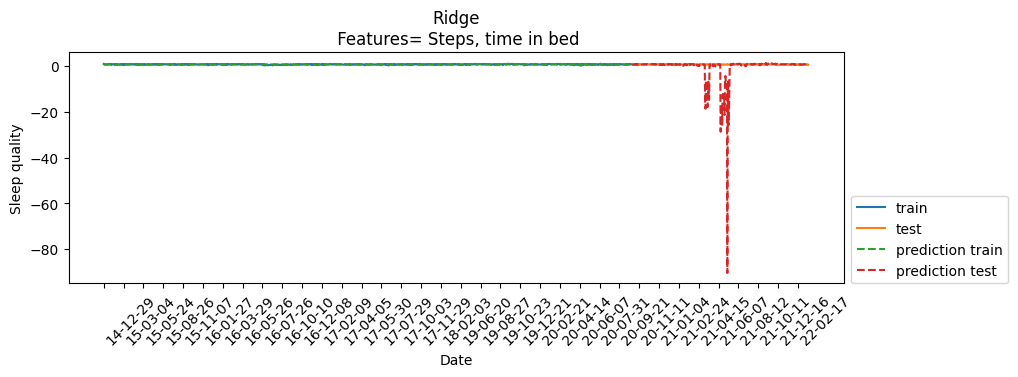

In [161]:
ridge = Ridge()
xtick_labels = pd.concat([df_train["Start"], df_test['Start']]).reset_index(drop=True)
xtick_labels = pd.DatetimeIndex(xtick_labels)
eval_on_features(X_train_enc_baseline, X_test_enc_baseline, y_train_baseline, y_test_baseline, ridge, xtick_labels=xtick_labels, feat_names="Steps, time in bed")